In [319]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [287]:
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [288]:
imgs1= unpickle("/home/raphael/Epita/MLRECO/PROJET/MLRF_PROJECT/data/external/data_batch_1")
imgs2= unpickle("/home/raphael/Epita/MLRECO/PROJET/MLRF_PROJECT/data/external/data_batch_2")
imgs3= unpickle("/home/raphael/Epita/MLRECO/PROJET/MLRF_PROJECT/data/external/data_batch_3")
imgs4= unpickle("/home/raphael/Epita/MLRECO/PROJET/MLRF_PROJECT/data/external/data_batch_4")
imgs5= unpickle("/home/raphael/Epita/MLRECO/PROJET/MLRF_PROJECT/data/external/data_batch_5")
all_images = np.concatenate((imgs1[b'data'], imgs2[b'data'], imgs3[b'data'], imgs4[b'data'], imgs5[b'data']))
all_labels = np.concatenate((imgs1[b'labels'], imgs2[b'labels'], imgs3[b'labels'], imgs4[b'labels'], imgs5[b'labels']))
data_labels = unpickle('/home/raphael/Epita/MLRECO/PROJET/MLRF_PROJECT/data/external/batches.meta')

In [289]:
def to_image(img_flat):
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    return img

In [290]:
def extract(data, label):
    descriptors = []
    labels = []
    fe = cv2.SIFT.create(nfeatures=50)
    for i, img in enumerate(data):
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, desc = fe.detectAndCompute(img, None)
        if desc is None:
            desc = np.zeros((1, 128), dtype="uint8")
        descriptors.append(desc)
        labels.append((label[i], len(desc)))
    return descriptors, labels

In [291]:
def normalize(descriptors):
    descriptors  = np.vstack(descriptors)
    descriptors = descriptors.astype(np.float32)
    mean = np.mean(descriptors)
    descriptors = np.apply_along_axis(lambda x: x - mean, axis=0, arr=descriptors)
    train_cov = np.dot(descriptors.T, descriptors)
    eigvals, eigvecs = np.linalg.eig(train_cov)
    perm = eigvals.argsort()
    pca_transform = eigvecs[:, perm[64:128]]
    descriptors = np.dot(descriptors, pca_transform)
    return descriptors

In [292]:
imgs_formatted = [to_image(img) for img in all_images]
labels_ = all_labels

In [293]:
descriptors, labels = extract(imgs_formatted, labels_)
descriptors = normalize(descriptors)

In [294]:
kmeans = KMeans(n_clusters=100).fit(descriptors)
print(kmeans.cluster_centers_.shape)

(100, 64)


In [307]:
def histogram(descriptors, labels, kmeans):
    descriptors_by_img = []
    labels2 = []
    i = 0
    for label, index in labels:
        descriptors_by_img.append(descriptors[i : i + index])
        labels2.append(label)
        i += index
    global_image_descr = np.zeros((len(descriptors_by_img), kmeans.n_clusters), dtype=np.float32)
    print(len(descriptors_by_img))
    print(len(labels2))
    for ii, desc in enumerate(descriptors_by_img):
        # get cluster ids
        prediction = kmeans.predict(desc)
        # compute histogram (do not forget to normalize by the number of descriptors)
        descr_hist = np.histogram(prediction, bins=kmeans.n_clusters)[0] / len(prediction)  # FIXME
        # update the index
        global_image_descr[ii] = descr_hist
    print(global_image_descr.shape)
    return global_image_descr, labels2

In [308]:
descriptors, labels = extract(imgs_formatted, labels_)
all_descriptors, all_labels_hist = histogram(normalize(descriptors), labels, kmeans)

50000
50000
(50000, 100)


In [309]:
# svm = SVC(kernel='poly', C=1.0)
# svm.fit(all_descriptors, all_labels)

In [310]:
lg = LogisticRegression()
lg.fit(all_descriptors, all_labels_hist)

LogisticRegression()

In [329]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(all_descriptors, all_labels_hist)
forest.score(all_descriptors, all_labels_hist)

0.2184

In [325]:
def test_model(model, imgs, labels, kmeans):
    desc, lbls = extract(imgs, labels)
    desc_hist, label_ = histogram(normalize(desc), lbls, kmeans)
    # prediction = model.predict(desc_hist)
    return model.score(desc_hist, labels)

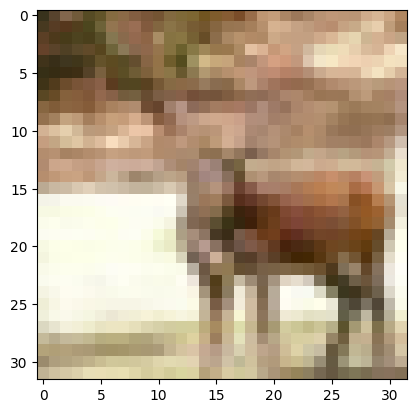

In [312]:
img_test = to_image(all_images[1001])
labe101 = all_labels[1001]

plt.imshow(img_test)

In [313]:
desc, label = extract([img_test], [labe101])
desc_norm = normalize(desc)
desc_hist, lbl = histogram(desc_norm, label, kmeans)

1
1
(1, 100)


In [314]:
# svm.predict(desc_hist)

In [315]:
data_labels[b'label_names'][9]

b'truck'

In [316]:
all_test = unpickle('/home/raphael/Epita/MLRECO/PROJET/MLRF_PROJECT/data/external/test_batch')

imgs_test = [to_image(img) for img in all_test[b"data"]]
labels_test = all_test[b"labels"]

In [317]:
# test_model(svm, imgs_test, labels_test, kmeans)

In [318]:
test_model(lg, imgs_test, labels_test, kmeans)

10000
10000
(10000, 100)


0.1189

In [330]:
test_model(forest, imgs_test, labels_test, kmeans)

10000
10000
(10000, 100)


0.1045